# Multivariate time series forecasting with Vector Auto Regression (VAR)


## Description

This notebook will use multiple environmental datasets, including Landsat satellite images, soil moisture, and rainfall to forecast vegetation condition (NDVI).


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datacube import Datacube

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from load_era5 import load_era5

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import grangercausalitytests

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35513 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


## Analysis parameters


In [3]:
# Define the analysis region (Lat-Lon box)
lat, lon = -17.8137, 125.3615 # native grasslandin Pilbara
buffer = 0.02

lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

# Define the time window
time = '2015-01-01', '2020-12-30'

#resample frequency
freq='1M'

#length of forecast
forecast_length = 2

#chunk sizes
dask_chunks={'x':-1, 'y':-1, 'time':-1}

In [4]:
display_map(lon,lat)

## Retrieve multiple environmental datasets

### Satellite data

In [5]:
dc = Datacube(app='VAR-forecast')

query = {'lon': lon,
         'lat': lat,
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

ds = load_ard(dc=dc, 
              dask_chunks=dask_chunks,
              products=["ga_ls7e_ard_3", "ga_ls8c_ard_3"],
              **query)


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 657 time steps as a dask array


#### Calculate NDVI time-series

In [6]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time=freq).mean()
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

Dropping bands ['nbart_red', 'nbart_nir']


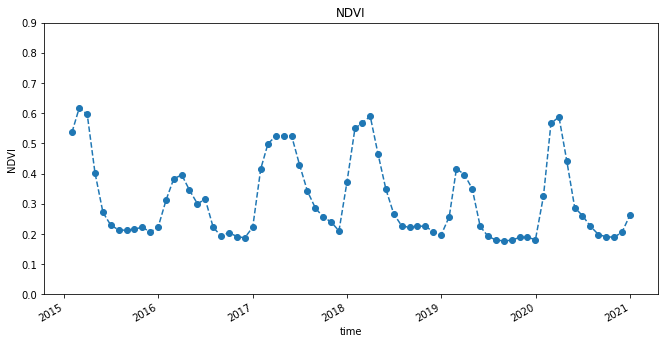

In [7]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.title('NDVI')
plt.ylim(0,0.9);

### Retrieval of surface and root-zone wetness

> `Surface wetness` is measured relative to wettest condition recorded for a location.

> `Rootzone Soil Water Index` is derived from surface relative wetness

In [8]:
# function to load soil moisture data
def load_soil_moisture(lat, lon, time, grid=None, product = 'surface'):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # define a grid that covers the entire area of interest
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05),
                          np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05),
                          np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'GRAFS_TopSoilRelativeWetness_'
    else: product_name = 'GRAFS_RootzoneSoilWaterIndex_'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

# Retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time) #grid='nearest'

# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone') #grid='nearest'

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2019.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2020.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRA

### Retrieve precipitation data from ERA5


In [9]:
# load precipitation data from ERA5
var_precipitation = 'precipitation_amount_1hour_Accumulation'
precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum, resample='1D')

# Convert from Meters (m) to Millimeters (mm)
precipitation[var_precipitation]=precipitation[var_precipitation]*1000

### Convert all datasets to 1D time-series

And resample to common time-step

In [10]:
precipitation=precipitation[var_precipitation].mean(['lat','lon']).drop('spatial_ref').compute()
surface_wetness=surface_wetness.relative_wetness.mean(['lat','lon'])
rootzone_wetness=rootzone_wetness.soil_water_index.mean(['lat','lon'])

In [11]:
precipitation=precipitation.resample(time=freq).sum()
surface_wetness=surface_wetness.resample(time=freq).mean()#.interpolate("linear")
rootzone_wetness=rootzone_wetness.resample(time=freq).mean()

### Plot all datasets together

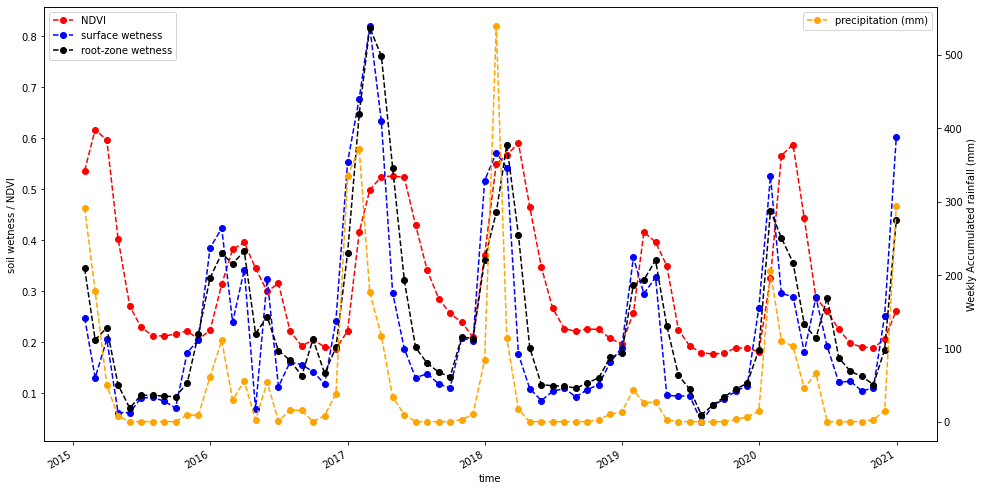

In [12]:
# plot soil moisture with precipitation
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
ndvi.plot(ax=ax1,label='NDVI',color='red',linestyle='dashed', marker='o')
surface_wetness.plot(ax = ax1,label='surface wetness',color='blue',linestyle='dashed', marker='o')
rootzone_wetness.plot(ax = ax1,label='root-zone wetness',color='black',linestyle='dashed', marker='o')
precipitation.plot(ax=ax2,label='precipitation (mm)',color='orange',linestyle='dashed', marker='o')
ax1.set_ylabel('soil wetness / NDVI')
ax2.set_ylabel('Weekly Accumulated rainfall (mm)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right');

### Convert datasets to a pandas dataframes

In [13]:
#convert to dfs
ndvi=ndvi.drop('spatial_ref').to_dataframe()
surface_wetness=surface_wetness.to_dataframe()
rootzone_wetness=rootzone_wetness.to_dataframe()
precipitation=precipitation.to_dataframe()

#add other variables to ndvi
ndvi['surface_wetness']=surface_wetness['relative_wetness']
ndvi['rootzone_wetness']=rootzone_wetness['soil_water_index']
ndvi['rainfall']=precipitation['precipitation_amount_1hour_Accumulation']

#drop an rows with nans
ndvi = ndvi.dropna()
ndvi.head()

,NDVI,surface_wetness,rootzone_wetness,rainfall
time,,,,
2015-01-31,0.536981,0.248307,0.345215,291.381836
2015-02-28,0.617195,0.130913,0.205263,177.886963
2015-03-31,0.596836,0.206209,0.228685,49.652100
2015-04-30,0.403412,0.062357,0.116940,7.812500
2015-05-31,0.271585,0.062582,0.071336,0.000000


## Convert to standardised anomalies?

## Test causation

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.
Below, we conduct a [Granger's Causality Test](https://en.wikipedia.org/wiki/Granger_causality) to see if the variables are related to each other.  In the table that's printed after running the two cells belows shows a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

In [14]:
def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [15]:
grangers_causation_matrix(ndvi, variables = ndvi.columns)  

,NDVI_x,surface_wetness_x,rootzone_wetness_x,rainfall_x
NDVI_y,1.0000,0.0,0.0000,0.0000
surface_wetness_y,0.0010,1.0,0.0015,0.1188
rootzone_wetness_y,0.0000,0.0,1.0000,0.0000
rainfall_y,0.0308,0.0,0.0002,1.0000


## Test for stationarity 

VAR models require the time series you want to forecast to be stationary. A stationary time series is one whose characteristics like mean and variance does not change over time. 
To test the stationarity, we can use a method called the [Augmented Dickey-Fuller Test (ADF Test)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/).

If the time-series are non-stationary, you can make it stationary by differencing the series once and repeating the test again until it becomes stationary. Differencing can be done easily using the following code snippet:

    df_differenced = df_train.diff().dropna()

Define a function for conducting an ADF test

In [16]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    ADF Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [17]:
# ADF Test on each column
for name, column in ndvi.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    ADF Test on "NDVI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.4604. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    ADF Test on "surface_wetness" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.3617. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    ADF Test on "rootzone_wetness" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    ADF Test on "rainfall" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## Conduct iterative back-test to validate forecasting ability

Here we will conduct a forecast, but over an interval of the time-series that we already have observations for. This will allow us to test the model's forecasting ability 

First, lets initiate a model

In [18]:
model=VAR(ndvi, freq=freq)

### Find the best lag order using Akaike information criterion (AIC)


Lag order to use is 2


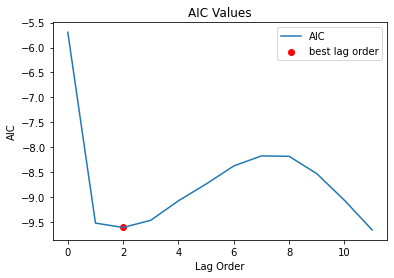

In [19]:
#calculate AIC
x=model.select_order()

#convert to pandas df
aic=pd.read_html(x.summary().as_html(),header=0, index_col=0)[0][['AIC']]
aic['AIC']=[float(i[0:6]) for i in aic.values.flatten()]

#find the first minimum in the series (not the lowest AIC but the first, lowest AIC)
asign=np.sign(aic.diff()) #first derivative
signchange = ((np.roll(asign, 1) - asign) != 0).astype(int) #where does the sign change?
lag_order=np.nonzero(~signchange.astype(bool).AIC.values)[0][0] #find first sign change

#plot
aic.plot()
plt.scatter(lag_order, aic.loc[lag_order], color='r', label='best lag order')
plt.title('AIC Values')
plt.ylabel('AIC')
plt.xlabel('Lag Order')
plt.legend()
print("Lag order to use is "+str(lag_order))

### Create and fit a model on the data

Using the lag order defined above

In [28]:
model=VAR(ndvi, freq=freq)
model_fit = model.fit(lag_order)

### Iteratively loop through the window size (for n number of windows) and forecast 

In [29]:
n_windows = int((len(ndvi) / forecast_length) - 1)
window_size = forecast_length

aa = window_size
dfs=[]
for i in range(0, n_windows):
    start=aa+lag_order
    end=(aa)
    backtest_input = ndvi.values[-start:-end] 
    fc = model_fit.forecast(y=backtest_input, steps=window_size)  
    if i == 0:
        index=ndvi.index[-end:]
    else:
        index=ndvi.index[-end:-(end-window_size)]
    fc = pd.DataFrame(fc, index=index, columns=ndvi.columns)
    dfs.append(fc)
    aa+=window_size                       

#concat results together
fc=pd.concat(dfs)

### Check RMSE of each variable

In [30]:
test=ndvi[ndvi.index.isin(fc.index)]
for i in test.columns:
    print('rmse value for', i, 'is : ', round(rmse(fc[[i]], test[[i]])[0],2))

rmse value for NDVI is :  0.17
rmse value for surface_wetness is :  0.18
rmse value for rootzone_wetness is :  0.18
rmse value for rainfall is :  86.86


### Plot the results of the back test

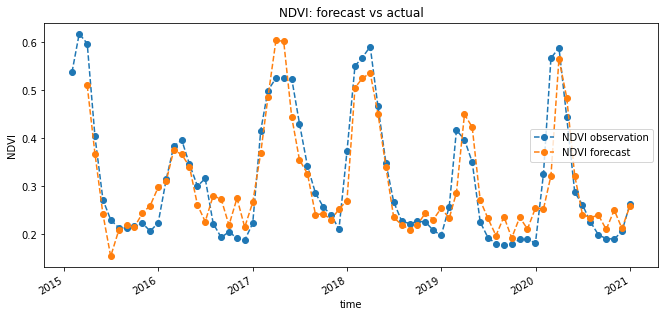

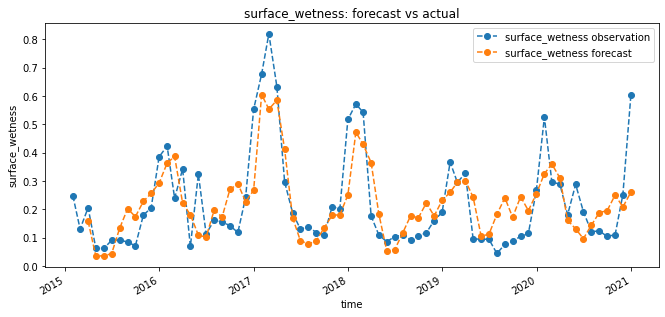

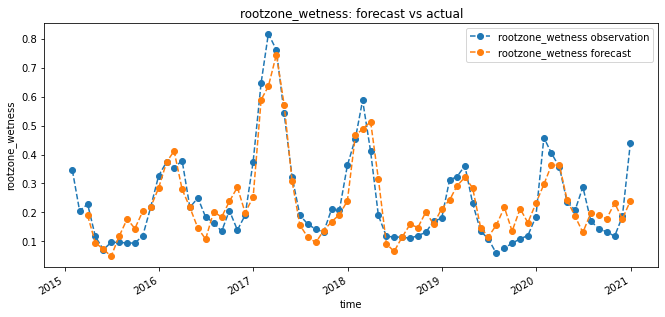

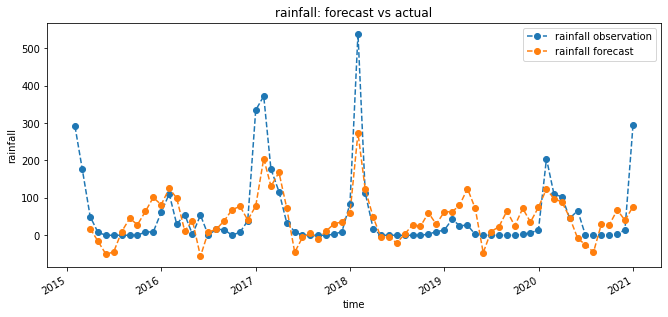

In [36]:
for col in ndvi.columns:
    plt.figure(figsize=(11,5))
    plt.plot(ndvi.index, ndvi[col], label=col+' observation',linestyle='dashed', marker='o')
    fc[col].plot(label=col+' forecast',linestyle='dashed', marker='o')
    plt.ylabel(col)
    plt.title(col+": forecast vs actual")
    plt.legend();

## Forecasting

In [24]:
#make final predictions
model = VAR(endog=ndvi,freq=freq)
model_fit = model.fit(lag_order)

pred = model_fit.forecast(ndvi.values[-model_fit.k_ar:], steps=forecast_length)

In [25]:
#converting predictions to dataframe
cols = ndvi.columns
fc = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        fc.iloc[i][j] = pred[i][j]

fc.index = pd.date_range(freq=freq, start=ndvi.index[-1], periods=len(fc)+1)[1:]
fc.head()

,NDVI,surface_wetness,rootzone_wetness,rainfall
2021-01-31,0.404441,0.557312,0.572385,200.287
2021-02-28,0.492725,0.52901,0.609085,121.301


### Plot the result of our forecast

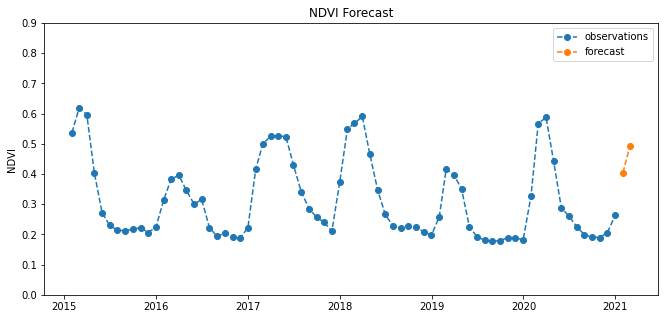

In [26]:
plt.figure(figsize=(11,5))
plt.plot(ndvi.index, ndvi['NDVI'], label='observations',linestyle='dashed', marker='o')
plt.plot(fc.index, fc[['NDVI']], label='forecast',linestyle='dashed', marker='o')
plt.ylabel('NDVI')
plt.title("NDVI Forecast")
plt.ylim(0.0,0.9)
plt.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 